In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pydrake.all import *

In [3]:
from underactuated import (FindResource, PlanarRigidBodyVisualizer)

In [4]:
builder = DiagramBuilder()
tree = RigidBodyTree(FindResource("cubli/cubli.urdf"),
                     FloatingBaseType.kFixed)
plant = RigidBodyPlant(tree)

In [5]:
nx = tree.get_num_positions() + tree.get_num_velocities()

allmaterials = CompliantMaterial()
allmaterials.set_youngs_modulus(1E9) # default 1E9
allmaterials.set_dissipation(1.0) # default 0.32
allmaterials.set_friction(1.0) # default 0.9.
plant.set_default_compliant_material(allmaterials)

context = plant.CreateDefaultContext()

In [6]:
robot = builder.AddSystem(plant)

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Spawning PlanarRigidBodyVisualizer for tree with 1 actuators
[-3.51882426e-01  2.57577457e-03  5.82197132e-02 -1.15901928e-02
 -2.59190542e-01 -2.73540919e-02 -1.78568983e+01 -1.72776998e-01
 -8.58448141e-02 -1.12543248e-01  2.85506285e-01 -5.21241412e-01
 -1.02970144e-01 -7.69425857e+00]


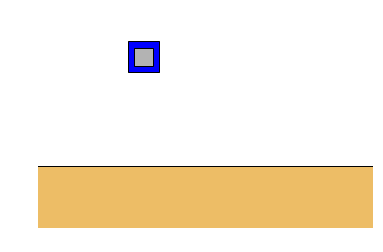

In [7]:
torque = 0.0
torque_system = builder.AddSystem(ConstantVectorSource(
    np.ones((tree.get_num_actuators(), 1))*torque))
builder.Connect(torque_system.get_output_port(0),
                robot.get_input_port(0))

vis = builder.AddSystem(PlanarRigidBodyVisualizer(tree, xlim=[-2.5, 2.5], ylim=[-1, 2.5]))
builder.Connect(robot.get_output_port(0),
                vis.get_input_port(0))

signalLogRate = 60
signalLogger = builder.AddSystem(SignalLogger(nx))
signalLogger._DeclarePeriodicPublish(1. / signalLogRate, 0.0)
builder.Connect(robot.get_output_port(0),
                signalLogger.get_input_port(0))

diagram = builder.Build()

simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1.0)
simulator.set_publish_every_time_step(False)

context = simulator.get_mutable_context()

state = context.get_mutable_state().get_mutable_continuous_state().get_mutable_vector()
state.SetFromVector((-1.0,0.,1.5,0.,0.,0.,0.,1.0,0.,1.0,0.,0.,0.,-10.0))

integrator = simulator.get_mutable_integrator()
integrator.set_fixed_step_mode(True)
integrator.set_maximum_step_size(0.0005)

simulator.StepTo(2)

print(state.CopyToVector())

ani = vis.animate(signalLogger, repeat=True)
plt.show()